### Copy of Lazy Programmer
Converted to TF 2.5

  0%|          | 0/500 [00:00<?, ?it/s]

episode: 0 total reward: 22.0 eps: 1.0 avg reward (last 100): 22.0
episode: 100 total reward: 200.0 eps: 0.09950371902099892 avg reward (last 100): 118.05940594059406
episode: 200 total reward: 200.0 eps: 0.07053456158585983 avg reward (last 100): 168.82178217821783
episode: 300 total reward: 150.0 eps: 0.0576390417704235 avg reward (last 100): 151.8118811881188
episode: 400 total reward: 200.0 eps: 0.04993761694389223 avg reward (last 100): 155.8118811881188
avg reward for last 100 episodes: 135.16
total steps: 72811.0


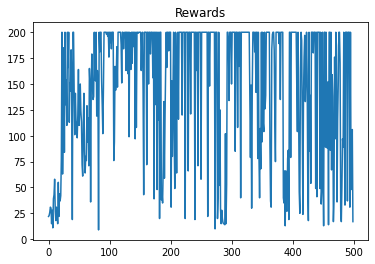

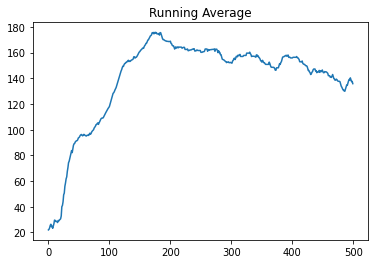

In [1]:
# https://deeplearningcourses.com/c/deep-reinforcement-learning-in-python
# https://www.udemy.com/deep-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import gym
import os
import sys
import numpy as np
from tqdm.notebook import trange
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
tf.compat.v1.disable_eager_execution()

# global counter
global_iters = 0


# a version of HiddenLayer that keeps track of params
class HiddenLayer:
  def __init__(self, M1, M2, f=tf.nn.tanh, use_bias=True):
    self.W = tf.Variable(tf.random.normal(shape=(M1, M2)))
    self.params = [self.W]
    self.use_bias = use_bias
    if use_bias:
      self.b = tf.Variable(np.zeros(M2).astype(np.float32))
      self.params.append(self.b)
    self.f = f

  def forward(self, X):
    if self.use_bias:
      a = tf.matmul(X, self.W) + self.b
    else:
      a = tf.matmul(X, self.W)
    return self.f(a)


class DQN:
  def __init__(self, D, K, hidden_layer_sizes, gamma, max_experiences=10000, min_experiences=100, batch_sz=32):
    self.K = K

    # create the graph
    self.layers = []
    M1 = D
    for M2 in hidden_layer_sizes:
      layer = HiddenLayer(M1, M2)
      self.layers.append(layer)
      M1 = M2

    # final layer
    layer = HiddenLayer(M1, K, lambda x: x)
    self.layers.append(layer)

    # collect params for copy
    self.params = []
    for layer in self.layers:
      self.params += layer.params

    # inputs and targets
    self.X = tf.compat.v1.placeholder(tf.float32, shape=(None, D), name='X')
    self.G = tf.compat.v1.placeholder(tf.float32, shape=(None,), name='G')
    self.actions = tf.compat.v1.placeholder(tf.int32, shape=(None,), name='actions')

    # calculate output and cost
    Z = self.X
    for layer in self.layers:
      Z = layer.forward(Z)
    Y_hat = Z
    self.predict_op = Y_hat

    selected_action_values = tf.compat.v1.reduce_sum(
      Y_hat * tf.one_hot(self.actions, K),
      reduction_indices=[1]
    )

    cost = tf.compat.v1.reduce_sum(tf.square(self.G - selected_action_values))
    self.train_op = tf.compat.v1.train.AdamOptimizer(1e-2).minimize(cost)
    # self.train_op = tf.train.AdagradOptimizer(1e-2).minimize(cost)
    # self.train_op = tf.train.MomentumOptimizer(1e-3, momentum=0.9).minimize(cost)
    # self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)

    # create replay memory
    self.experience = {'s': [], 'a': [], 'r': [], 's2': [], 'done': []}
    self.max_experiences = max_experiences
    self.min_experiences = min_experiences
    self.batch_sz = batch_sz
    self.gamma = gamma

  def set_session(self, session):
    self.session = session

  def copy_from(self, other):
    # collect all the ops
    ops = []
    my_params = self.params
    other_params = other.params
    for p, q in zip(my_params, other_params):
      actual = self.session.run(q)
      op = p.assign(actual)
      ops.append(op)
    # now run them all
    self.session.run(ops)

  def predict(self, X):
    X = np.atleast_2d(X)
    return self.session.run(self.predict_op, feed_dict={self.X: X})

  def train(self, target_network):
    # sample a random batch from buffer, do an iteration of GD
    if len(self.experience['s']) < self.min_experiences:
      # don't do anything if we don't have enough experience
      return

    # randomly select a batch
    idx = np.random.choice(len(self.experience['s']), size=self.batch_sz, replace=False)
    # print("idx:", idx)
    states = [self.experience['s'][i] for i in idx]
    actions = [self.experience['a'][i] for i in idx]
    rewards = [self.experience['r'][i] for i in idx]
    next_states = [self.experience['s2'][i] for i in idx]
    dones = [self.experience['done'][i] for i in idx]
    next_Q = np.max(target_network.predict(next_states), axis=1)
    targets = [r + self.gamma*next_q if not done else r for r, next_q, done in zip(rewards, next_Q, dones)]

    # call optimizer
    self.session.run(
      self.train_op,
      feed_dict={
        self.X: states,
        self.G: targets,
        self.actions: actions
      }
    )

  def add_experience(self, s, a, r, s2, done):
    if len(self.experience['s']) >= self.max_experiences:
      self.experience['s'].pop(0)
      self.experience['a'].pop(0)
      self.experience['r'].pop(0)
      self.experience['s2'].pop(0)
      self.experience['done'].pop(0)
    self.experience['s'].append(s)
    self.experience['a'].append(a)
    self.experience['r'].append(r)
    self.experience['s2'].append(s2)
    self.experience['done'].append(done)

  def sample_action(self, x, eps):
    if np.random.random() < eps:
      return np.random.choice(self.K)
    else:
      X = np.atleast_2d(x)
      return np.argmax(self.predict(X)[0])


def play_one(env, model, tmodel, eps, gamma, copy_period):
  global global_iters
  observation = env.reset()
  done = False
  totalreward = 0
  iters = 0
  while not done and iters < 2000:
    # if we reach 2000, just quit, don't want this going forever
    # the 200 limit seems a bit early
    action = model.sample_action(observation, eps)
    prev_observation = observation
    observation, reward, done, info = env.step(action)

    totalreward += reward
    if done:
      reward = -200

    # update the model
    model.add_experience(prev_observation, action, reward, observation, done)
    model.train(tmodel)

    iters += 1
    global_iters += 1

    if global_iters % copy_period == 0:
      tmodel.copy_from(model)

  return totalreward

def plot_running_avg(totalrewards):
  N = len(totalrewards)
  running_avg = np.empty(N)
  for t in range(N):
    running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
  plt.plot(running_avg)
  plt.title("Running Average")
  plt.show()

def main():
  env = gym.make('CartPole-v0')
  gamma = 0.99
  copy_period = 50

  D = len(env.observation_space.sample())
  K = env.action_space.n
  sizes = [200,200]
  model = DQN(D, K, sizes, gamma)
  tmodel = DQN(D, K, sizes, gamma)
  init = tf.compat.v1.global_variables_initializer()
  session = tf.compat.v1.InteractiveSession()
  session.run(init)
  model.set_session(session)
  tmodel.set_session(session)


  if 'monitor' in sys.argv:
    filename = os.path.basename(__file__).split('.')[0]
    monitor_dir = './' + filename + '_' + str(datetime.now())
    env = wrappers.Monitor(env, monitor_dir)


  N = 500
  totalrewards = np.empty(N)
  costs = np.empty(N)
  for n in trange(N):
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, tmodel, eps, gamma, copy_period)
    totalrewards[n] = totalreward
    if n % 100 == 0:
      print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

  print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
  print("total steps:", totalrewards.sum())

  plt.plot(totalrewards)
  plt.title("Rewards")
  plt.show()

  plot_running_avg(totalrewards)

main()
